In [7]:
# -*- coding: utf-8 -*-
"""
Leyla Tarhan
10/2020
functions for variance partitioning analyses. Assumes you just want to compare 2 models.
"""

# %% dependencies

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# %% testing setup

# nObs = 100;
# nVars = 5; 

# # generate some random data:
# X1 = np.random.rand(nObs, nVars);
# X2 = np.random.rand(nObs, nVars);
# Y = np.random.rand(nObs, 1);

# # call it:
# rSquared = predictAllModels(X1, X2, Y);
# partitions = partitionVariance(rSquared);

# # other variants:
# bigRSquared = bigRSquaredAllModels(X1, X2, Y); # calculate traditional R^2 instead of cross-validation r^2
# partitions = partitionVariance(rSquared);

# rSquaredRidge = predictAllModelsRidge(X1, X2, Y); # use ridge regression to minimize the effects of collinearity on the combo model
# partitions = partitionVariance(rSquared);

# %%  fit all the regressions using cross-validation

# input: individual X's and Y to predict
# output: r-squared for each combo of X's (as a dictionary)

def predictAllModels(X1, X2, Y):
    
    # set up the models:
    if X1.ndim == 1 and X2.ndim == 1:
        comboModel = np.stack((X1, X2), axis = 1)
    else:
        comboModel = np.concatenate((X1, X2), axis = 1)
        
    models = [X1, X2, comboModel]
    modelNames = ['X1', 'X2', 'X1&X2']
    
    # loop through the models:
    rSquared = {};
    for m in range(len(models)):
        currModel = models[m];
        
        # use this model to predict Y:
        predictions = [];
        for o in range(len(Y)):
            # hold out this observation:
            x_train = np.delete(currModel, (o), axis = 0)
            y_train = np.delete(Y, o, 0)
            x_test = currModel[o];
            
            if currModel.ndim == 1:
                
                # fit the regression (re-shape the data first so everything's a 2-d array)
                x_train_2d = x_train.reshape(-1, 1);
                y_train_2d = y_train.reshape(-1, 1);
                reg = LinearRegression().fit(x_train_2d, y_train_2d)
                
                # predict the held-out observation:
                x_test_2d = x_test.reshape(1, -1)
                predictions.append(reg.predict(x_test_2d)[0][0])

            else:
                # fit the regression (no reshaping necessary, since already a 2d array)
                reg = LinearRegression().fit(x_train, y_train)
                
                # predict the held-out observation
                x_test_2d = x_test.reshape(1, -1)
                predictions.append(reg.predict(x_test_2d)[0])
            
            
        # correlate predicted / actual Y-values:
        predictionsArray = np.asarray(predictions)
        r = np.corrcoef(predictionsArray, Y, rowvar = False)[0][1]
        rSign = r/abs(r)
        # rSquared[modelNames[m]] = r**2 # NOT keeping the sign
        rSquared[modelNames[m]] = r**2 * rSign # keeping the sign, as in Lescroart et al. (2015)
        
    return rSquared
        
# %%  fit all the regressions using traditional R-squared

# input: individual X's and Y to explain
# output: traditional R-squared for each combo of X's (as a dictionary)

def bigRSquaredAllModels(X1, X2, Y):
    
    # set up the models:
    if X1.ndim == 1 and X2.ndim == 1:
        comboModel = np.stack((X1, X2), axis = 1)
    else:
        comboModel = np.concatenate((X1, X2), axis = 1)

    models = [X1, X2, comboModel]
    modelNames = ['X1', 'X2', 'X1&X2']       
        
    # loop through the models:
    bigRSquared = {};
    for m in range(len(models)):
        currModel = models[m];
        
        if currModel.ndim == 1:
            # re-format the data to be 2d
            currModel_2d = currModel.reshape(-1, 1)
            Y_2d = Y.reshape(-1, 1)
            
            # use this model to explain Y
            reg = LinearRegression().fit(currModel_2d, Y_2d);
            R2 = reg.score(currModel_2d, Y_2d);
        else:
            # use this model to explain Y
            reg = LinearRegression().fit(currModel, Y);
            R2 = reg.score(currModel, Y);
            
        # record the R2 for this model
        bigRSquared[modelNames[m]] = R2
    
        
    return bigRSquared
    

# %% fit all the regressions using cross-validation and ridge regularization

# input: individual X's and Y to predict
# output: r-squared for each combo of X's (as a dictionary)
# [] may need to make this more robust to 1-d inputs

def predictAllModelsRidge(X1, X2, Y):
    
    # set up the models:
    if X1.ndim == 1 and X2.ndim == 1:
        comboModel = np.stack((X1, X2), axis = 1)
    else:
        comboModel = np.concatenate((X1, X2), axis = 1)
        
    models = [X1, X2, comboModel]
    modelNames = ['X1', 'X2', 'X1&X2']
    
    # loop through the models:
    rSquaredRidge = {};
    for m in range(len(models)):
        currModel = models[m];
        
        # use this model to predict Y:
        predictions = [];
        for o in range(len(Y)):
            # hold out this observation:
            x_train = np.delete(currModel, (o), axis = 0)
            y_train = np.delete(Y, o, 0)
            x_test = currModel[o].reshape(1, -1);
            # y_test = Y[o,];
            
            # fit the regression:
            ridgeReg = Ridge(alpha = 1.0)
            ridgeReg.fit(x_train, y_train)
            
            # predict the held-out observation:
            predictions.append(ridgeReg.predict(x_test)[0])
            
            
        # correlated predicted / actual Y-values:
        predictionsArray = np.asarray(predictions)
        r = np.corrcoef(predictionsArray, np.ndarray.flatten(Y), rowvar = False)[0][1];
        rSign = r/abs(r)
        # rSquared[modelNames[m]] = r**2 # NOT keeping the sign
        rSquaredRidge[modelNames[m]] = r**2 * rSign # keeping the sign, as in Lescroart et al. (2015)
        
    return rSquaredRidge


# %% do variance partitioning

# input: r-squared values from all combo's of predictors
# output: dictionary of each partion of the variance


def partitionVariance(rSquared):
    
    partitions = {};
        
    # set up the models to expect:
    modelNames = ['X1', 'X2'];
        
    # get the unique variance for each model (X):
    for m in modelNames:
        # unique variance accounted for by *this model ALONE* = variance 
        # accounted for by the combo of both models - variance accounted for 
        # by the other model
        
        otherModel = modelNames[:];
        otherModel.remove(m);
        otherModel = otherModel[0];
        partitions[m + '-unique'] = rSquared['X1&X2'] - rSquared[otherModel]
        
    # get the variance that's shared between X1 & X2:
    # r^2 model 1 + r^2 model 2 - r^2 duo
    partitions['X1&X2-shared'] = rSquared['X1'] + rSquared['X2'] - rSquared['X1&X2'];
    
    return partitions

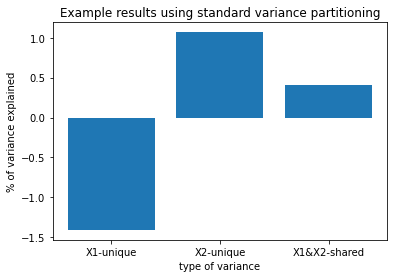

In [8]:
# -*- coding: utf-8 -*-
"""
Leyla Tarhan
12/2020
Example showing how to call the variance partitioning functions using simulated data.
"""
# %% Dependencies

#from Helpers import *
import numpy as np
import matplotlib.pyplot as plt

# %% simulate some data

# comparing 2 sets of variables, which each have 5 dimensions (e.g., 5 ways to measure air quality) and 100 observations. 
# Note: this method should work to compare any 2 sets of variables, no matter how many dimensions they have.
nObs = 100;
nVars = 5; 

# generate some random data:
X1 = np.random.rand(nObs, nVars);
X2 = np.random.rand(nObs, nVars);
Y = np.random.rand(nObs, 1);

# %% do standard variance partitioning

# predict Y using all 3 combinations of X1 & X2:
rSquared = predictAllModels(X1, X2, Y);

# partition the variance:
partitions = partitionVariance(rSquared);

# plot the results:
plotLabels = list(partitions.keys())
variances = [i*100 for i in list(partitions.values())]
plt.bar(plotLabels, variances)
plt.xlabel('type of variance')
plt.ylabel('% of variance explained')
plt.title('Example results using standard variance partitioning')
plt.show()





variance measurement: cross-validated...
iteration 10/1000...
iteration 20/1000...
iteration 30/1000...
iteration 40/1000...
iteration 50/1000...
iteration 60/1000...
iteration 70/1000...
iteration 80/1000...
iteration 90/1000...
iteration 100/1000...
iteration 110/1000...
iteration 120/1000...
iteration 130/1000...
iteration 140/1000...
iteration 150/1000...
iteration 160/1000...
iteration 170/1000...
iteration 180/1000...
iteration 190/1000...
iteration 200/1000...
iteration 210/1000...
iteration 220/1000...
iteration 230/1000...
iteration 240/1000...
iteration 250/1000...
iteration 260/1000...
iteration 270/1000...
iteration 280/1000...
iteration 290/1000...
iteration 300/1000...
iteration 310/1000...
iteration 320/1000...
iteration 330/1000...
iteration 340/1000...
iteration 350/1000...
iteration 360/1000...
iteration 370/1000...
iteration 380/1000...
iteration 390/1000...
iteration 400/1000...
iteration 410/1000...
iteration 420/1000...
iteration 430/1000...
iteration 440/1000..

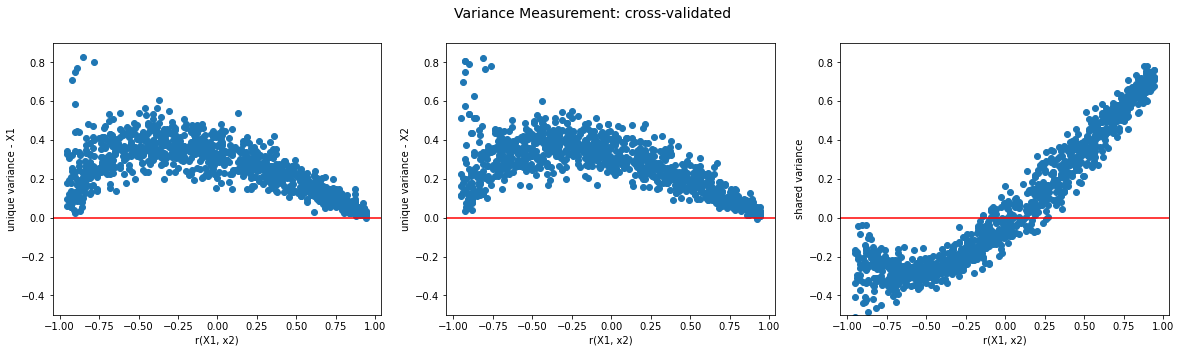



variance measurement: R2...
iteration 10/1000...
iteration 20/1000...
iteration 30/1000...
iteration 40/1000...
iteration 50/1000...
iteration 60/1000...
iteration 70/1000...
iteration 80/1000...
iteration 90/1000...
iteration 100/1000...
iteration 110/1000...
iteration 120/1000...
iteration 130/1000...
iteration 140/1000...
iteration 150/1000...
iteration 160/1000...
iteration 170/1000...
iteration 180/1000...
iteration 190/1000...
iteration 200/1000...
iteration 210/1000...
iteration 220/1000...
iteration 230/1000...
iteration 240/1000...
iteration 250/1000...
iteration 260/1000...
iteration 270/1000...
iteration 280/1000...
iteration 290/1000...
iteration 300/1000...
iteration 310/1000...
iteration 320/1000...
iteration 330/1000...
iteration 340/1000...
iteration 350/1000...
iteration 360/1000...
iteration 370/1000...
iteration 380/1000...
iteration 390/1000...
iteration 400/1000...
iteration 410/1000...
iteration 420/1000...
iteration 430/1000...
iteration 440/1000...
iteration 4

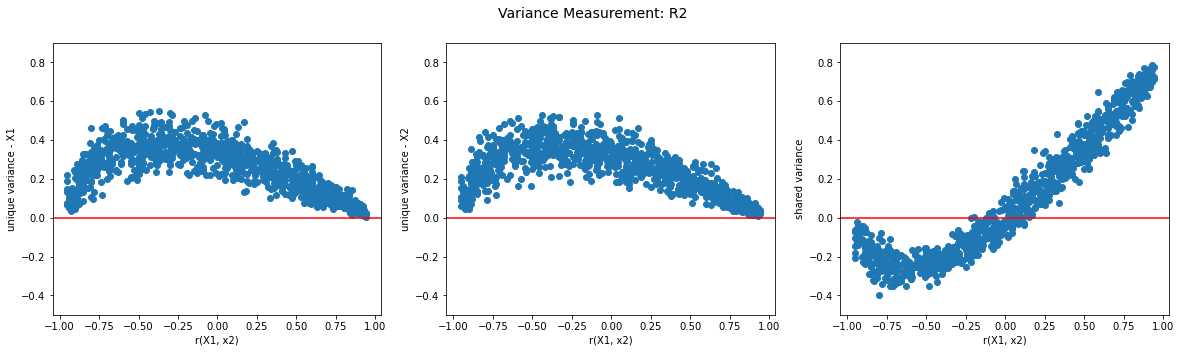



DONE!


In [10]:

# -*- coding: utf-8 -*-
"""
Leyla Tarhan
12/2020
Code exploring cases where you might find negative shared variance, using simulations.
Main strategy: simulate 1-d data (X1 and X2) and some observations (Y). 
Vary how correlated X1 and X2 are, and assess whether you get negative 
partitioned variance at any level of correlation.
Many thanks to Dan Janini for the method I used in these simulations, and to 
Ruosi Wang for additional ideas!
"""
# %% load dependencies

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
import random

# my helpers:

# %% set up simulation parameters
# always comparing 2 models

nObs = 100; # observations in the data
nVars = 1; # dimensions in each 'model' (X1 or X2)
nIters = 1000; # simulation iterations
corrRange = np.arange(-.95, 0.95, 0.01); # possible correlations between x1 & x2
errorSD = 1; # standard deviation of the error term for simulating Y

# %% run simulations

# Does it matter whether you measure variance explained using cross-validation?
# try 2 methods: cross-validated r^2 and traditional R^2
rSquaredTypes = ['cross-validated', 'R2']

# loop through the ways of measuring variance explained
for r in rSquaredTypes:
    # set up to store the results for this analysis type
    uniqueX1 = [];
    uniqueX2 = [];
    shared = [];
    corrs = [];
    
    print('\n\nvariance measurement: ' + r + '...')
    # loop through the iterations
    for i in range(nIters):   
        if (i+1)%10 == 0:
            print('iteration ' + str(i+1) + '/' + str(nIters) + '...')
        
        # generate X1 & X2 & Y
        currCorr = random.sample(list(corrRange), 1)[0]
        corrs.append(currCorr)
        corr_mat= np.array([[1.0, currCorr],
                    [currCorr, 1.0]])
        upper_chol = cholesky(corr_mat) # cholesky decomposition
        rnd = np.random.normal(0.0, 1.0, size=(nObs, 2)) # 2 random vectors drawn from a normal distribution
        rndCorr = rnd @ upper_chol # cholesky decomposition * random vectors
        X1 = rndCorr[:,0]
        X2 = rndCorr[:,1]
        # np.corrcoef(X1, X2) # to check that the correlation is as expected
        
        # Y = X1 + X2 + error
        error = np.random.normal(0.0, errorSD, size = (nObs)); # error drawn from distribution centered on 0 (manipulate the variance)
        YElements = np.stack((X1, X2, error), axis = 1)
        Y = np.sum(YElements, axis = 1)
        
        # variance partitioning based on current analysis type
        if r == 'cross-validated':
            # fit all the regressions to get cross-validated r^2 for each combo of regressors
            rSquared = predictAllModels(X1, X2, Y);
        elif r == 'R2':
            rSquared = bigRSquaredAllModels(X1, X2, Y);
        else:
            print('didn''t recognize that analysis type.')
            
        # partition the variance
        partitions = partitionVariance(rSquared);
        
        # store this iteration's results  
        uniqueX1.append(partitions['X1-unique'])
        uniqueX2.append(partitions['X2-unique'])
        shared.append(partitions['X1&X2-shared'])

        
        
    # scatterplots to visualize the results:
    f, axs = plt.subplots(1, 3, figsize = (20, 5))
    plt.setp(axs, ylim=(-0.5, 0.9))
    f.suptitle("Variance Measurement: " + r, fontsize=14)
    axs[0,].scatter(corrs, uniqueX1); axs[0,].set_xlabel('r(X1, x2)'); axs[0,].set_ylabel('unique variance - X1'); axs[0,].axhline(y=0, color = 'r')
    axs[1,].scatter(corrs, uniqueX2); axs[1,].set_xlabel('r(X1, x2)'); axs[1,].set_ylabel('unique variance - X2'); axs[1,].axhline(y=0, color = 'r')
    axs[2,].scatter(corrs, shared); axs[2,].set_xlabel('r(X1, x2)'); axs[2,].set_ylabel('shared variance'); axs[2,].axhline(y=0, color = 'r')    
    plt.show()

print('\n\nDONE!')
